# DS Existence Module Impact

**Goal:** Demonstrate the impact of Lima's DS existence module on multi-sensor fusion by comparing:
- **WITH existence module** (current implementation)
- **WITHOUT existence module** (accepting all tracks regardless of existence belief)

**Key Metrics:**
- Ghost tracks
- False associations (mis-associations)
- Tracking errors
- Total track count vs ground truth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from typing import Dict, List, Tuple

from config import (NUM_VEHICLES, NUM_TIME_STEPS, OBJECT_INITIAL_STATES,
                   NUM_OBJECTS, SENSOR_TYPES, DT, E_FORGET, TAU_CONF)
from objects import ObjectSimulator
from vehicle_agent import VehicleAgent
from evaluation import TrackingEvaluator

# Set style
plt.style.use('default')
%matplotlib inline

print("Imports ok")

Imports ok


## 1. Create Modified Vehicle Agent (No Existence Filtering)

In [2]:
class VehicleAgentNoExistence(VehicleAgent):
    """Modified VehicleAgent that bypasses DS existence filtering.

    This version accepts ALL tracks regardless of existence belief,
    including tentative and decaying tracks that would normally be filtered out.
    """

    def process_timestep(self, object_states):
        """Process timestep but accept ALL tracks regardless of existence."""
        # Get measurements
        measurements_by_sensor = self.sensor_array.measure_objects(object_states)

        # Process through single-sensor trackers (still uses existence internally)
        for sensor_id, tracker in enumerate(self.single_sensor_trackers):
            detections = measurements_by_sensor[sensor_id]
            tracker.process_detections(detections)

        # Get ALL track states
        sensor_tracks = []
        for tracker in self.single_sensor_trackers:
            all_track_dicts = tracker.get_track_states()
            sensor_tracks.append(all_track_dicts)

        # Fuse all tracks (no filtering based on existence)
        fused_tracks = self.fusion.fuse_sensor_tracks(sensor_tracks)

        return fused_tracks

print("✓ VehicleAgentNoExistence class created")

✓ VehicleAgentNoExistence class created


## 2. Simulation Runner Function

In [3]:
def run_simulation_variant(use_existence_filter: bool, seed: int = 42) -> Tuple[TrackingEvaluator, Dict]:
    """Run simulation with or without existence filtering.

    Args:
        use_existence_filter: If True, use normal VehicleAgent with existence filtering
                             If False, use VehicleAgentNoExistence that bypasses filtering
        seed: Random seed for reproducibility

    Returns:
        (evaluator, metrics_history)
    """
    np.random.seed(seed)

    # Initialize objects
    object_sim = ObjectSimulator(OBJECT_INITIAL_STATES)

    # Initialize vehicles (with or without existence filtering)
    if use_existence_filter:
        vehicles = [VehicleAgent(i) for i in range(NUM_VEHICLES)]
        variant_name = "WITH Existence Module"
    else:
        vehicles = [VehicleAgentNoExistence(i) for i in range(NUM_VEHICLES)]
        variant_name = "WITHOUT Existence Module"

    print(f"\n{'='*70}")
    print(f"Running Simulation: {variant_name}")
    print(f"{'='*70}")

    # Initialize evaluator
    evaluator = TrackingEvaluator(NUM_OBJECTS)

    # Metrics storage
    metrics_history = {
        'time_steps': [],
        'ghost_tracks': [],
        'false_associations': [],
        'missed_objects': [],
        'total_tracks': [],
        'rmse_error': []
    }

    # Run simulation
    for t in range(NUM_TIME_STEPS):
        # Get true states
        true_states = object_sim.get_states()

        # Process vehicles
        for vehicle in vehicles:
            fused_tracks = vehicle.process_timestep(true_states)

        # Evaluate
        evaluator.evaluate_timestep(t, true_states, vehicles)

        # Collect metrics
        history = evaluator.get_history()
        if history['overall_metrics']:
            latest = history['overall_metrics'][-1]
            metrics_history['time_steps'].append(t)
            metrics_history['ghost_tracks'].append(latest['ghost_tracks'])
            metrics_history['false_associations'].append(latest['false_associations'])
            metrics_history['missed_objects'].append(latest['missed_objects'])
            metrics_history['total_tracks'].append(latest['num_tracks'])
            metrics_history['rmse_error'].append(latest['rmse_tracking_error'])

        # Update objects
        object_sim.step()

        if (t + 1) % 10 == 0:
            print(f"Step {t+1:3d}/{NUM_TIME_STEPS}: "
                  f"Tracks={latest['num_tracks']:.1f}, "
                  f"Ghosts={latest['ghost_tracks']:.1f}, "
                  f"FalseAssoc={latest['false_associations']:.1f}")

    print(f"{'='*70}\n")

    return evaluator, metrics_history

print("its run")

its run


## 3. Run Both Experiments

In [4]:
print("\n" + "="*80)
print("COMPARATIVE EXPERIMENT: Impact of DS Existence Module")
print("="*80)
print(f"\nConfiguration:")
print(f"- Time steps: {NUM_TIME_STEPS}")
print(f"- Vehicles: {NUM_VEHICLES}")
print(f"- Objects: {NUM_OBJECTS}")
print(f"- Sensors per vehicle: {len(SENSOR_TYPES)} ({', '.join(SENSOR_TYPES)})")
print(f"- DS Parameters: E_FORGET={E_FORGET}, TAU_CONF={TAU_CONF}")

# Run WITHOUT existence module
print("\n[1/2] Running simulation WITHOUT existence module...")
evaluator_without, metrics_without = run_simulation_variant(
    use_existence_filter=False,
    seed=42
)

# Run WITH existence module
print("\n[2/2] Running simulation WITH existence module...")
evaluator_with, metrics_with = run_simulation_variant(
    use_existence_filter=True,
    seed=42
)

print("\nBoth simulations completed !")


COMPARATIVE EXPERIMENT: Impact of DS Existence Module

Configuration:
- Time steps: 50
- Vehicles: 3
- Objects: 4
- Sensors per vehicle: 3 (camera, radar, lidar)
- DS Parameters: E_FORGET=0.6, TAU_CONF=0.75

[1/2] Running simulation WITHOUT existence module...

Running Simulation: WITHOUT Existence Module
Step  10/50: Tracks=3.3, Ghosts=1.0, FalseAssoc=0.3
Step  20/50: Tracks=4.7, Ghosts=1.3, FalseAssoc=1.3
Step  30/50: Tracks=4.0, Ghosts=0.3, FalseAssoc=2.0
Step  40/50: Tracks=6.7, Ghosts=2.7, FalseAssoc=1.0
Step  50/50: Tracks=5.0, Ghosts=2.0, FalseAssoc=1.3


[2/2] Running simulation WITH existence module...

Running Simulation: WITH Existence Module
Step  10/50: Tracks=3.3, Ghosts=0.3, FalseAssoc=0.7
Step  20/50: Tracks=4.7, Ghosts=1.0, FalseAssoc=1.0
Step  30/50: Tracks=5.0, Ghosts=1.3, FalseAssoc=1.0
Step  40/50: Tracks=6.3, Ghosts=2.3, FalseAssoc=0.3
Step  50/50: Tracks=4.7, Ghosts=1.0, FalseAssoc=1.0


Both simulations completed !


## 4. Summary Statistics

In [5]:
# Check if we have data
if len(metrics_without['ghost_tracks']) == 0 or len(metrics_with['ghost_tracks']) == 0:
    print("ERROR: No metrics collected. Please run cell 3 above first.")
else:
    # Create summary dataframe
    summary_data = {
        'Metric': [
            'Ghost Tracks (avg/vehicle)',
            'False Associations (avg/vehicle)',
            'Missed Objects (avg/vehicle)',
            'Total Tracks (avg/vehicle)',
            'RMSE Tracking Error (m)'
        ],
        'Without Module': [
            metrics_without['ghost_tracks'][-1],
            metrics_without['false_associations'][-1],
            metrics_without['missed_objects'][-1],
            metrics_without['total_tracks'][-1],
            metrics_without['rmse_error'][-1]
        ],
        'With Module': [
            metrics_with['ghost_tracks'][-1],
            metrics_with['false_associations'][-1],
            metrics_with['missed_objects'][-1],
            metrics_with['total_tracks'][-1],
            metrics_with['rmse_error'][-1]
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    summary_df['Improvement'] = summary_df['Without Module'] - summary_df['With Module']
    summary_df['Improvement %'] = (summary_df['Improvement'] / summary_df['Without Module'].replace(0, 1) * 100).round(1)

    print("\n" + "="*80)
    print("IMPACT OF DS EXISTENCE MODULE")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)

    # Key findings
    ghost_reduction = summary_df.loc[summary_df['Metric'] == 'Ghost Tracks (avg/vehicle)', 'Improvement %'].values[0]
    false_reduction = summary_df.loc[summary_df['Metric'] == 'False Associations (avg/vehicle)', 'Improvement %'].values[0]


IMPACT OF DS EXISTENCE MODULE
                          Metric  Without Module  With Module  Improvement  Improvement %
      Ghost Tracks (avg/vehicle)        2.000000     1.000000     1.000000           50.0
False Associations (avg/vehicle)        1.333333     1.000000     0.333333           25.0
    Missed Objects (avg/vehicle)        1.000000     0.333333     0.666667           66.7
      Total Tracks (avg/vehicle)        5.000000     4.666667     0.333333            6.7
         RMSE Tracking Error (m)        1.128402     1.785747    -0.657345          -58.3


## 5. Comprehensive Visualization

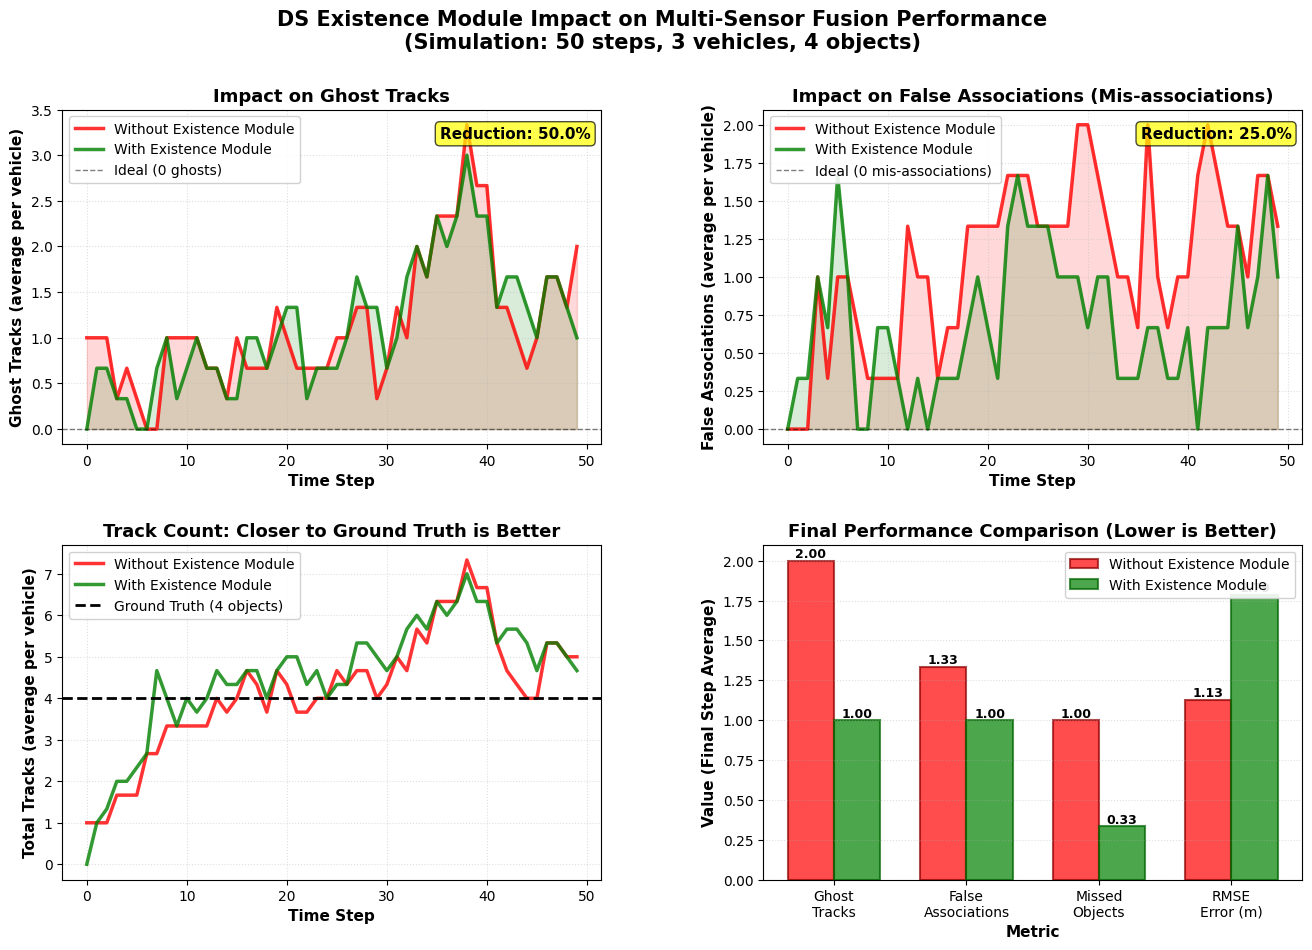


Comparison plot saved to: existence_module_impact.png


In [6]:
# Check if we have data
if len(metrics_without['ghost_tracks']) == 0 or len(metrics_with['ghost_tracks']) == 0:
    print("ERROR: No metrics to plot. Please run cell 3 above first.")
else:
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    time_steps_with = metrics_with['time_steps']
    time_steps_without = metrics_without['time_steps']

    # --- Subplot 1: Ghost Tracks Over Time ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time_steps_without, metrics_without['ghost_tracks'],
             'r-', linewidth=2.5, label='Without Existence Module', alpha=0.8)
    ax1.plot(time_steps_with, metrics_with['ghost_tracks'],
             'g-', linewidth=2.5, label='With Existence Module', alpha=0.8)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Ideal (0 ghosts)')
    ax1.fill_between(time_steps_without, 0, metrics_without['ghost_tracks'],
                      color='red', alpha=0.15)
    ax1.fill_between(time_steps_with, 0, metrics_with['ghost_tracks'],
                      color='green', alpha=0.15)

    ax1.set_xlabel('Time Step', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Ghost Tracks (average per vehicle)', fontsize=11, fontweight='bold')
    ax1.set_title('Impact on Ghost Tracks', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax1.grid(True, linestyle=':', alpha=0.4)

    # Add reduction annotation
    ax1.text(0.98, 0.95, f'Reduction: {ghost_reduction:.1f}%',
             transform=ax1.transAxes, fontsize=11, fontweight='bold',
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    # --- Subplot 2: False Associations Over Time ---
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(time_steps_without, metrics_without['false_associations'],
             'r-', linewidth=2.5, label='Without Existence Module', alpha=0.8)
    ax2.plot(time_steps_with, metrics_with['false_associations'],
             'g-', linewidth=2.5, label='With Existence Module', alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Ideal (0 mis-associations)')
    ax2.fill_between(time_steps_without, 0, metrics_without['false_associations'],
                      color='red', alpha=0.15)
    ax2.fill_between(time_steps_with, 0, metrics_with['false_associations'],
                      color='green', alpha=0.15)

    ax2.set_xlabel('Time Step', fontsize=11, fontweight='bold')
    ax2.set_ylabel('False Associations (average per vehicle)', fontsize=11, fontweight='bold')
    ax2.set_title('Impact on False Associations (Mis-associations)', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax2.grid(True, linestyle=':', alpha=0.4)

    # Add reduction annotation
    ax2.text(0.98, 0.95, f'Reduction: {false_reduction:.1f}%',
             transform=ax2.transAxes, fontsize=11, fontweight='bold',
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    # --- Subplot 3: Total Tracks vs Ground Truth ---
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(time_steps_without, metrics_without['total_tracks'],
             'r-', linewidth=2.5, label='Without Existence Module', alpha=0.8)
    ax3.plot(time_steps_with, metrics_with['total_tracks'],
             'g-', linewidth=2.5, label='With Existence Module', alpha=0.8)
    ax3.axhline(y=NUM_OBJECTS, color='black', linestyle='--', linewidth=2,
                label=f'Ground Truth ({NUM_OBJECTS} objects)')

    ax3.set_xlabel('Time Step', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Total Tracks (average per vehicle)', fontsize=11, fontweight='bold')
    ax3.set_title('Track Count: Closer to Ground Truth is Better', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax3.grid(True, linestyle=':', alpha=0.4)

    # --- Subplot 4: Summary Bar Chart ---
    ax4 = fig.add_subplot(gs[1, 1])

    metrics_names = ['Ghost\nTracks', 'False\nAssociations', 'Missed\nObjects', 'RMSE\nError (m)']

    without_vals = [
        metrics_without['ghost_tracks'][-1],
        metrics_without['false_associations'][-1],
        metrics_without['missed_objects'][-1],
        metrics_without['rmse_error'][-1]
    ]

    with_vals = [
        metrics_with['ghost_tracks'][-1],
        metrics_with['false_associations'][-1],
        metrics_with['missed_objects'][-1],
        metrics_with['rmse_error'][-1]
    ]

    x = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax4.bar(x - width/2, without_vals, width, label='Without Existence Module',
                    color='red', alpha=0.7, edgecolor='darkred', linewidth=1.5)
    bars2 = ax4.bar(x + width/2, with_vals, width, label='With Existence Module',
                    color='green', alpha=0.7, edgecolor='darkgreen', linewidth=1.5)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax4.set_xlabel('Metric', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Value (Final Step Average)', fontsize=11, fontweight='bold')
    ax4.set_title('Final Performance Comparison (Lower is Better)', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics_names, fontsize=10)
    ax4.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax4.grid(True, axis='y', linestyle=':', alpha=0.4)

    # Overall title
    fig.suptitle('DS Existence Module Impact on Multi-Sensor Fusion Performance\n'
                 f'(Simulation: {NUM_TIME_STEPS} steps, {NUM_VEHICLES} vehicles, {NUM_OBJECTS} objects)',
                 fontsize=15, fontweight='bold', y=0.98)

    plt.savefig('existence_module_impact.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nComparison plot saved to: existence_module_impact.png")

## 6. Statistical Analysis

In [7]:
# Check if we have data
if len(metrics_without['ghost_tracks']) == 0 or len(metrics_with['ghost_tracks']) == 0:
    print("ERROR: No metrics collected. Please run cell 3 above first.")
else:
    # Average over all time steps
    avg_stats = {
        'Metric': [
            'Ghost Tracks (mean over time)',
            'False Associations (mean over time)',
            'Total Tracks (mean over time)',
            'RMSE Error (mean over time)'
        ],
        'Without Module': [
            np.mean(metrics_without['ghost_tracks']),
            np.mean(metrics_without['false_associations']),
            np.mean(metrics_without['total_tracks']),
            np.mean(metrics_without['rmse_error'])
        ],
        'With Module': [
            np.mean(metrics_with['ghost_tracks']),
            np.mean(metrics_with['false_associations']),
            np.mean(metrics_with['total_tracks']),
            np.mean(metrics_with['rmse_error'])
        ]
    }

    avg_df = pd.DataFrame(avg_stats)
    avg_df['Improvement'] = avg_df['Without Module'] - avg_df['With Module']
    avg_df['Improvement %'] = (avg_df['Improvement'] / avg_df['Without Module'].replace(0, 1) * 100).round(1)

    print("\n" + "="*80)
    print("AVERAGE PERFORMANCE OVER ALL TIME STEPS")
    print("="*80)
    print(avg_df.to_string(index=False))
    print("="*80)


AVERAGE PERFORMANCE OVER ALL TIME STEPS
                             Metric  Without Module  With Module  Improvement  Improvement %
      Ghost Tracks (mean over time)        1.146667     1.113333     0.033333            2.9
False Associations (mean over time)        1.100000     0.693333     0.406667           37.0
      Total Tracks (mean over time)        4.173333     4.520000    -0.346667           -8.3
        RMSE Error (mean over time)        1.716734     1.221576     0.495158           28.8
